# Part IV: Sentiment analysis using LSTM [20 points]
In this part, we perform a sentiment analysis using LSTM model. The final (improved) model should achieve a test accuracy of greater than 75%.

In [27]:
#Import necessary libraries and modules
import re
import time
import nltk
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory
from sklearn.metrics import classification_report, confusion_matrix
DetectorFactory.seed = 0  
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/shreyas/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [37]:
%matplotlib inline

In [3]:
import torch
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

1.13.1
CUDA Available: True
CUDA Version: 11.8


## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the main statistics

In [38]:
#Loading the dataset into a dataframe
df = pd.read_csv("amazon_review_polarity_dataset.csv")

#Prints the main stats of the dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      99998 non-null   object
 1   review     100000 non-null  object
 2   sentiment  100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


,sentiment
count,100000.000000
mean,1.500000
std,0.500003
min,1.000000
25%,1.000000
50%,1.500000
75%,2.000000
max,2.000000


2. Print the first 5 rows of the dataset to understand its structure

In [5]:
#Prints the first 5 rows
df.head()

,title,review,sentiment
0,I'm back in the 70's,Did it feel great popping in this CD (awesome ...,2
1,"Great knives, but watch out lefties!",I agree with all of the accolades given to thi...,2
2,Better late than never? Not!,After placing and paying for a subscription on...,1
3,Live 101 Volume 2,I enjoyed this volume even more than the first...,2
4,A Moving Piece of Work! Only To Sky Rocket!,This new group is phenomenal! I can't speak hi...,2


3. Provide a brief description of the dataset

### `Dataset Description:`

- This dataset contains Amazon reviews where each entry has a title, review text, and a sentiment label.
- The Amazon Reviews Polarity dataset is constructed by taking reviews with scores of 1 and 2 as negative (class 1) and scores of 4 and 5 as positive (class 2). Reviews with a score of 3 are ignored.
- The dataset contains 400000 entries in all and it has been sourced from kaggle website. 
- But the original source of the dataset is constructed by Xiang Zhang and used as a text classification benchmark. We use the csv file from the original source found from the google drive and linked in the kaggle website too.
- Source: [Kaggle.com](https://www.kaggle.com/datasets/bittlingmayer/amazonreviews?select=test.ft.txt.bz2) 
/ [Drive](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ)

4. Display descriptive statistics

In [30]:
def print_analysis(df):
    
    #Gives the no. of samples
    num_samples = df.shape[0]
    print("\nTotal number of samples:", num_samples)
    
    class_dist = df['sentiment'].value_counts(normalize=True) * 100
    print("\nClass distribution (in percentage):")
    print(class_dist)
    
    #Calculates the review lengths in words and char
    df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))
    df['char_count'] = df['review'].apply(lambda x: len(str(x)))
    avg_words = df['word_count'].mean()
    avg_chars = df['char_count'].mean()
    print("\nAverage review length: {:.2f} words, {:.2f} characters".format(avg_words, avg_chars))
    
    #Gives the vocabulary size
    all_words = " ".join(df['review'].astype(str)).lower().split()
    vocab_size = len(set(all_words))
    print("\nVocabulary size (unique words):", vocab_size)

In [31]:
print_analysis(df)


Total number of samples: 100000

Class distribution (in percentage):
sentiment
2    50.0
1    50.0
Name: proportion, dtype: float64

Average review length: 74.42 words, 406.52 characters

Vocabulary size (unique words): 318377


5. Handle missing values

In [32]:
def handle_miss(df):
    
    mis_counts = df.isnull().sum()
    print("\nMissing values per column:")
    print(mis_counts)
    
    df_clean = df.dropna().reset_index(drop=True)
    print("\nNumber of samples after dropping missing values:", df_clean.shape[0])
    return df_clean

In [34]:
df1 = handle_miss(df)
df1


Missing values per column:
title         2
review        0
sentiment     0
word_count    0
char_count    0
dtype: int64

Number of samples after dropping missing values: 99998


,title,review,sentiment,word_count,char_count
0,I'm back in the 70's,Did it feel great popping in this CD (awesome ...,2,40,216
1,"Great knives, but watch out lefties!",I agree with all of the accolades given to thi...,2,170,935
2,Better late than never? Not!,After placing and paying for a subscription on...,1,63,385
3,Live 101 Volume 2,I enjoyed this volume even more than the first...,2,51,300
4,A Moving Piece of Work! Only To Sky Rocket!,This new group is phenomenal! I can't speak hi...,2,73,430
...,...,...,...,...,...
99993,Fiction,After the latest scholarly evaluation and inve...,1,43,267
99994,An Unforgettable Novel!!,I loved all the Chronicles trilogy but dragons...,2,81,440
99995,Yum,"This shiped on the estimated date, so thats go...",2,65,444
99996,longest yard cd,Was not happy with the item. Was expecting the...,1,42,237


`Chosen Method:`  We simply removed rows with missing values using dropna(). Since only a tiny fraction of our text data (about 30 out of 400,000+ rows) was affected, this approach avoids the complications and biases of imputation while still leaving us with a large, representative dataset.

6. Create visualizations to gain insights into the data

In [35]:
def vis_data(df):
    
    #Plots a histogram of review lengths
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df['word_count'], bins=30, color='skyblue', edgecolor='black')
    plt.title("Histogram of Review Lengths (words)")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    plt.hist(df['char_count'], bins=30, color='lightgreen', edgecolor='black')
    plt.title("Histogram of Review Lengths (characters)")
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
    
    print("\n")
    
    #Plots the word clouds for each class
    for sentiment in sorted(df['sentiment'].unique()):
        reviews_text = " ".join(df[df['sentiment'] == sentiment]['review'].astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Sentiment {sentiment}")
        plt.show()
    
    #Plots a bar plot for number of reviews per sentiment class
    plt.figure(figsize=(9, 5))
    ax = sns.countplot(x='sentiment', data=df, hue='sentiment', palette='pastel', legend=False)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title("Number of Reviews per Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()
    
    #Plots the top 20 most common words
    reviews_text = " ".join(df['review'].astype(str)).lower()
    words = re.findall(r'\w+', reviews_text)
    common_words = Counter(words).most_common(20)
    words_list, counts = zip(*common_words)
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(words_list), y=list(counts), hue=list(words_list), palette='viridis', legend=False)
    plt.title("Top 20 Most Common Words in Reviews")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

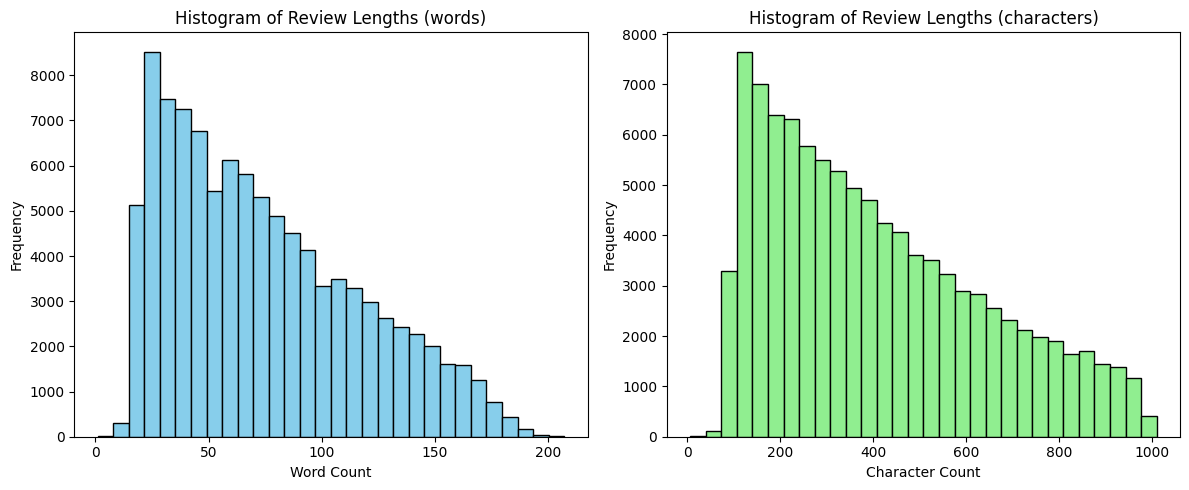

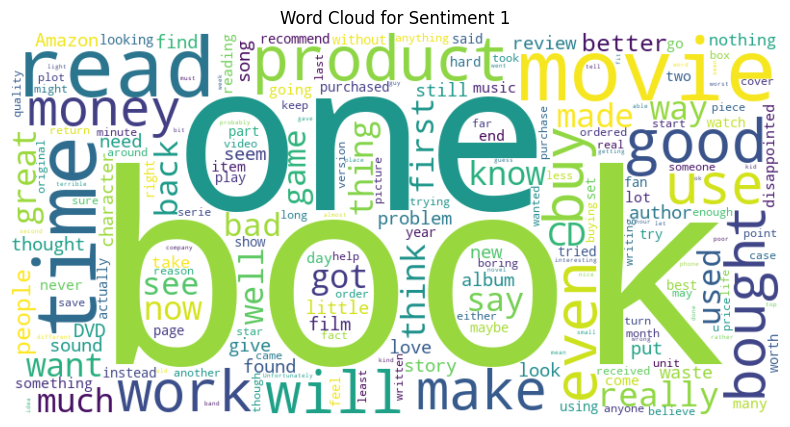

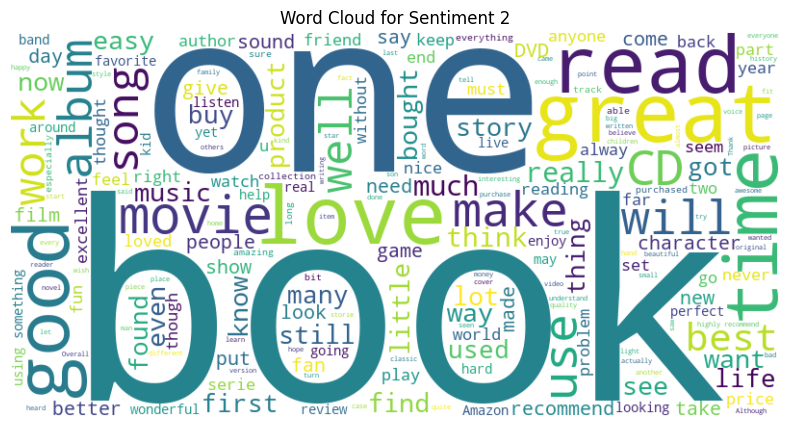

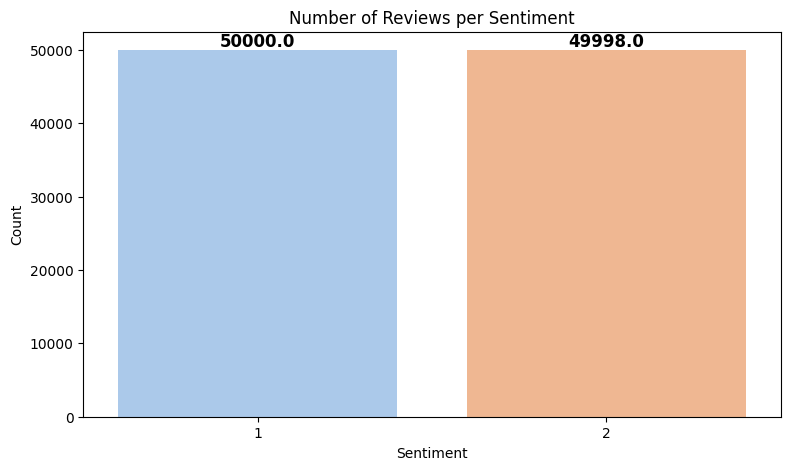

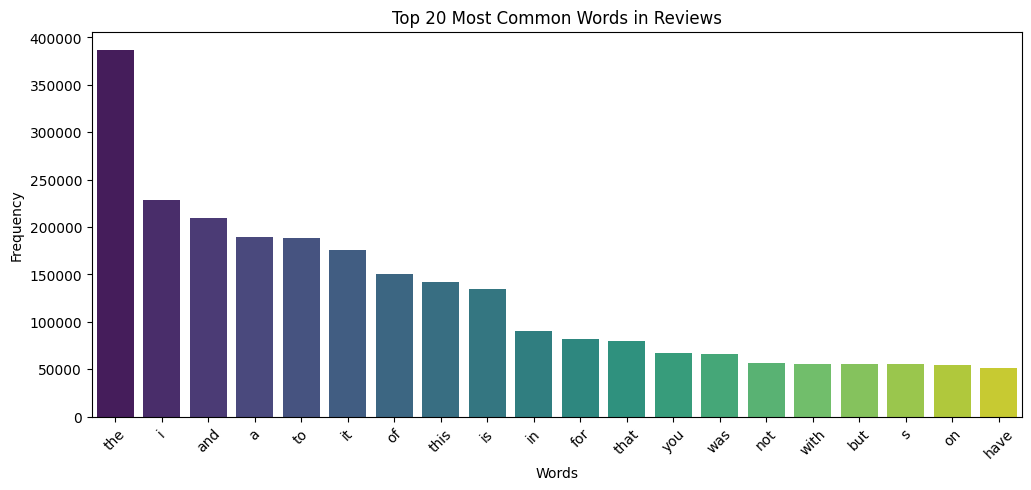

In [36]:
vis_data(df1)

7. Data preparation

In [28]:
#Defining few helper functions

def cmp_t(texts):

    #Method 1: NLTK
    start = time.perf_counter()
    t_nltk = [word_tokenize(text) for text in texts]
    time_nltk = time.perf_counter() - start

    #Method 2: torchtext's basic_english tokenizer
    tokenizer_basic = get_tokenizer("basic_english")
    start = time.perf_counter()
    t_basic = [tokenizer_basic(text) for text in texts]
    time_basic = time.perf_counter() - start

    #Computes the vocabulary sizes
    v_nltk = set(token for tokens in t_nltk for token in tokens)
    v_basic = set(token for tokens in t_basic for token in tokens)

    print(f"NLTK tokenizer: Time = {time_nltk:.4f} sec, Vocabulary size = {len(v_nltk)}")
    print(f"Basic English tokenizer: Time = {time_basic:.4f} sec, Vocabulary size = {len(v_basic)}")
    
    return t_nltk, t_basic


#Yields tokens from a list of tokenized texts
def yield_t(tokenized_texts):
    for tokens in tokenized_texts: 
        yield tokens


#Converts tokens to numerical sequences using vocab
def num_texts(tokenized_texts, vocab):
    return [[vocab[token] for token in tokens] for tokens in tokenized_texts] 

#Pads short seq and truncates the longer ones
def pad(seq, max_len):

    padded = []
    for s in seq:
        if len(s) > max_len:
            s = s[:max_len]  #Truncates the longer sequences
        else:
            s = s + [0] * (max_len - len(s))  #Pads the shorter sequences with zeros
        padded.append(torch.tensor(s))
    return torch.stack(padded)


#Processes the text data
def process_text(text, stop_words):

    text = text.lower()
    text = text.replace('$', ' dollar ')
    text = re.sub(r'[^a-z0-9\s\.]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]

    return " ".join(tokens)


#Removes spanish reviews out
def rem_spanish(df):
    def is_es(text):
            try:
                return detect(text) == 'es'
            except Exception:
                return False
        
    _df_ = df[~df['review'].apply(is_es)].reset_index(drop=True)
    return _df_


#Final preprocesser using all helper functions
def final(df):
    
    #Removes spanish reviews
    df = rem_spanish(df)
    
    #Cleans text
    stop_words = set(stopwords.words('english'))
    df['title'] = df['title'].astype(str).apply(lambda x: process_text(x, stop_words))
    df['review'] = df['review'].astype(str).apply(lambda x: process_text(x, stop_words))
    
    #Maps 1 -> 0 (negative) and 2 -> 1 (positive)
    df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 1 else 1)
    
    return df


def preprocess(df, vocab, max_len, tokenizer):
    texts = df['review'].tolist()
    tokens = [tokenizer(text) for text in texts]
    sequences = num_texts(tokens, vocab)
    padded_sequences = pad(sequences, max_len)
    df['review_seq'] = padded_sequences.tolist()
    
    return df

8. Split dataset into train, validation, and test sets

In [9]:
#Splits the dataset to train, val and test sets
train_df, temp_df = train_test_split(df1, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [10]:
#Processes the data and cleans it 
train = final(train_df).reset_index(drop=True)
val= final(val_df).reset_index(drop=True)
test = final(test_df).reset_index(drop=True)

In [11]:
                                    # --------------------------- #
                                    # Experiment with Tokenizers  #
                                    # --------------------------- #
            
            
t_texts = train['review'].tolist()
sample_texts = t_texts[:10000]    #Uses a smaller subset for easier computational analysis
tokens_nltk, tokens_basic = cmp_t(sample_texts)

NLTK tokenizer: Time = 3.2046 sec, Vocabulary size = 41100
Basic English tokenizer: Time = 0.3051 sec, Vocabulary size = 37176


### `Final choice:` 
We choose basic_english tokenizer as it is faster and yields a more manageable vocabulary.

In [12]:
tokenizer = get_tokenizer("basic_english")
train_tokens = [tokenizer(text) for text in t_texts]


                                # --------------------------- #
                                # Build Vocabulary from data  #
                                # --------------------------- #
            
            
vocab = build_vocab_from_iterator(yield_t(train_tokens), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  #sets default index for unknown tokens
print("Vocabulary size:", len(vocab))

Vocabulary size: 127502


In [13]:
                            # --------------------------------------------- #
                            # Convert Training Texts to Numerical Sequences #
                            # --------------------------------------------- #
            
train_seq = num_texts(train_tokens, vocab)

#Determines the max seq length as 95th percentile of train seq
train_len = [len(seq) for seq in train_seq]
max_len = int(np.percentile(train_len, 95))
print("Max sequence length (95th percentile):", max_len)

train_pad = pad(train_seq, max_len)
print("Padded training sequences shape:", train_pad.shape)

Max sequence length (95th percentile): 93
Padded training sequences shape: torch.Size([79860, 93])


`Impact of Padding & Truncation:`

In my experiments, I normalized input sequences by indicating a maximum length in terms of the 95th percentile (93 tokens). I cut off longer reviews and padded shorter ones with zeros. Few findings from experiments:

- Truncation: Truncating too harshly lead to loss of critical sentiment cues, especially if the most important information is beyond the cutoff.
- Padding: Yet excessive padding introduced noise into the training because the model needed to be trained to ignore such uninformative zeros.
 
Selecting the 95th percentile as the max sequence length permitted me to address these issues by allowing the majority of the reviews to maintain their critical information without inundating the model with padding.

In [14]:
#Processes all the sets with the same tokenizer, vocab & pad length
train_pad = preprocess(train, vocab, max_len, word_tokenize)
val_pad = preprocess(val, vocab, max_len, word_tokenize)
test_pad = preprocess(test, vocab, max_len, word_tokenize)

In [15]:
print("\nFinal preprocessed dataset split:")
print(f"Train: {train_pad.shape[0]} samples")
print(f"Validation: {val_pad.shape[0]} samples")
print(f"Test: {test_pad.shape[0]} samples\n")


Final preprocessed dataset split:
Train: 79860 samples
Validation: 9975 samples
Test: 9988 samples



## Step 2: Baseline LSTM Model

1. Build an LSTM model

In [29]:
class LSTM_Sentiment_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dims, output_size, dropout):
    
        super(LSTM_Sentiment_Model, self).__init__()
        
        #Embedding layer to map word indices
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #1st layer
        self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dims[0], batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        
        #2nd layer
        self.lstm2 = nn.LSTM(input_size=hidden_dims[0], hidden_size=hidden_dims[1], batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        
        #3rd layer
        self.lstm3 = nn.LSTM(input_size=hidden_dims[1], hidden_size=hidden_dims[2], batch_first=True)
        self.dropout3 = nn.Dropout(dropout)
        
        #Fully connected layer
        self.fc1 = nn.Linear(hidden_dims[2], hidden_dims[2] // 2)
        self.fc2 = nn.Linear(hidden_dims[2] // 2, output_size)
        
    def forward(self, x):
    
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.dropout3(x)
        x = x[:, -1, :]  
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x #We have raw logits here as output

                                    # ----------------------------- #
                                    # Model Parameters and Summary  #
                                    # ----------------------------- #  

#Using dummy input to show summary of model                
dummy_input = torch.randint(0, 10000, (32, 100))
model = LSTM_Sentiment_Model(10000, 128, [128, 64, 32], 1, 0.5)
summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Sentiment_Model                     [32, 1]                   --
├─Embedding: 1-1                         [32, 100, 128]            1,280,000
├─LSTM: 1-2                              [32, 100, 128]            132,096
├─Dropout: 1-3                           [32, 100, 128]            --
├─LSTM: 1-4                              [32, 100, 64]             49,664
├─Dropout: 1-5                           [32, 100, 64]             --
├─LSTM: 1-6                              [32, 100, 32]             12,544
├─Dropout: 1-7                           [32, 100, 32]             --
├─Linear: 1-8                            [32, 16]                  528
├─Linear: 1-9                            [32, 1]                   17
Total params: 1,474,849
Trainable params: 1,474,849
Non-trainable params: 0
Total mult-adds (M): 662.75
Input size (MB): 0.03
Forward/backward pass size (MB): 9.02
Params size (MB): 5.90
Estimated Total S

2. Train your model

In [30]:
class SentimentDataset(Dataset):
    def __init__(self, df):
        self.sequences = df['review_seq'].tolist()
        self.labels = df['sentiment'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        seq = torch.tensor(self.sequences[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return seq, label

       
    
                                        # ---------------- #
                                        # DataLoader Setup #
                                        # ---------------- #
batch_size = 32
train_dataset = SentimentDataset(train_pad)  
val_dataset = SentimentDataset(val_pad)        
test_dataset = SentimentDataset(test_pad)      
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
                                            # --------- #
                                            #   Setup   #
                                            # --------- #
#Defines hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
output_size = 1 
batch_size = 32
num_epochs = 5

#Candidates for tuning
learning_rates = [0.001, 0.0005]                                                      
hidden_dims_options = [[128, 64, 32], [256, 128, 64]]  
dropout_rates = [0.5, 0.3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM_Sentiment_Model(vocab_size, embedding_dim, hidden_dims, output_size, dropout).to(device)

best_val_acc = 0.0
best_config = None
best_metrics = None
best_model_state = None

In [33]:
def train_LSTM(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    
    train_l = []
    train_a = []
    val_l = []
    val_a = []
    
    for epoch in range(num_epochs):
                                        # -------------- #
                                        # Training Loop  #
                                        # -------------- #
        model.train() 
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()             
            outputs = model(sequences)          
            loss = criterion(outputs.view(-1), labels.view(-1))
            loss.backward()                   
            optimizer.step()                  
            
            running_train_loss += loss.item() * sequences.size(0)
            #For predictions apply the sigmoid to convert logits to prob
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_train += (preds.view(-1) == labels.view(-1)).sum().item()
            total_train += labels.size(0)
        
        epoch_train_loss = running_train_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_l.append(epoch_train_loss)
        train_a.append(epoch_train_acc)
        
        
        model.eval()  
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs.view(-1), labels.view(-1))
                running_val_loss += loss.item() * sequences.size(0)
                preds = (torch.sigmoid(outputs) >= 0.5).float()
                correct_val += (preds.view(-1) == labels.view(-1)).sum().item()
                total_val += labels.size(0)
        
        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_l.append(epoch_val_loss)
        val_a.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} -> "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    return train_l, train_a, val_l, val_a

### `Tuning Strategy: Grid Search`

We use a grid search (a manual, systematic search) to explore a range of hyperparameter combinations. Specifically, we vary learning rates, hidden dim layers, dropout rate. For each combination, the model is trained and its performance is monitored on the validation set. The best model is chosen based on the highest validation accuracy. Then, the best model is evaluated on the test set to report additional metrics.


Training with: lr=0.001, hidden_dims=[128, 64, 32], dropout=0.5

Epoch 1/5 -> Train Loss: 0.6907, Train Acc: 0.5174 | Val Loss: 0.6835, Val Acc: 0.5572
Epoch 2/5 -> Train Loss: 0.6864, Train Acc: 0.5503 | Val Loss: 0.6826, Val Acc: 0.5588
Epoch 3/5 -> Train Loss: 0.6877, Train Acc: 0.5395 | Val Loss: 0.7201, Val Acc: 0.5991
Epoch 4/5 -> Train Loss: 0.5519, Train Acc: 0.7058 | Val Loss: 0.5079, Val Acc: 0.7160
Epoch 5/5 -> Train Loss: 0.4640, Train Acc: 0.7508 | Val Loss: 0.4974, Val Acc: 0.7217


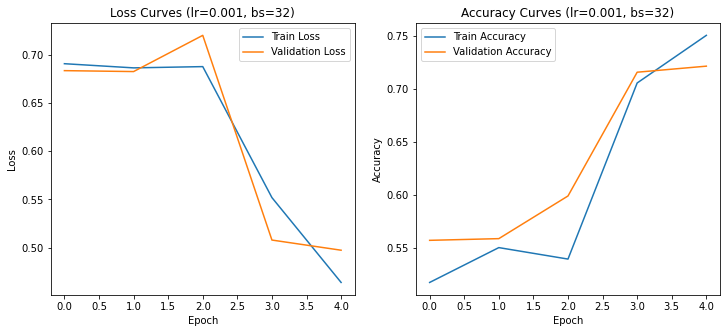


Training with: lr=0.001, hidden_dims=[128, 64, 32], dropout=0.3

Epoch 1/5 -> Train Loss: 0.6915, Train Acc: 0.5166 | Val Loss: 0.6897, Val Acc: 0.5376
Epoch 2/5 -> Train Loss: 0.6768, Train Acc: 0.5658 | Val Loss: 0.5686, Val Acc: 0.7182
Epoch 3/5 -> Train Loss: 0.4224, Train Acc: 0.8161 | Val Loss: 0.3664, Val Acc: 0.8394
Epoch 4/5 -> Train Loss: 0.2937, Train Acc: 0.8826 | Val Loss: 0.3622, Val Acc: 0.8472
Epoch 5/5 -> Train Loss: 0.2223, Train Acc: 0.9173 | Val Loss: 0.3735, Val Acc: 0.8489


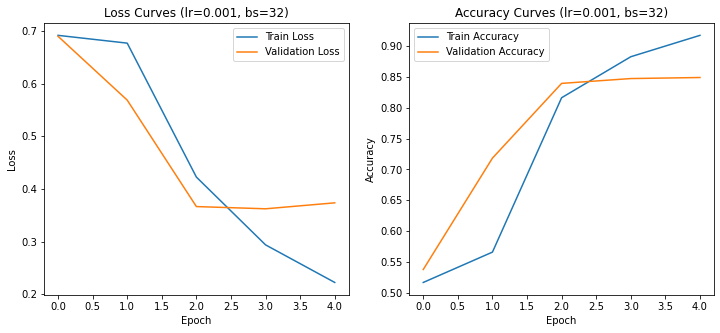


Training with: lr=0.001, hidden_dims=[256, 128, 64], dropout=0.5

Epoch 1/5 -> Train Loss: 0.6934, Train Acc: 0.4988 | Val Loss: 0.6932, Val Acc: 0.4959
Epoch 2/5 -> Train Loss: 0.6933, Train Acc: 0.4985 | Val Loss: 0.6931, Val Acc: 0.5041
Epoch 3/5 -> Train Loss: 0.6933, Train Acc: 0.4982 | Val Loss: 0.6932, Val Acc: 0.4959
Epoch 4/5 -> Train Loss: 0.6932, Train Acc: 0.4989 | Val Loss: 0.6931, Val Acc: 0.5041
Epoch 5/5 -> Train Loss: 0.6932, Train Acc: 0.4999 | Val Loss: 0.6931, Val Acc: 0.5041


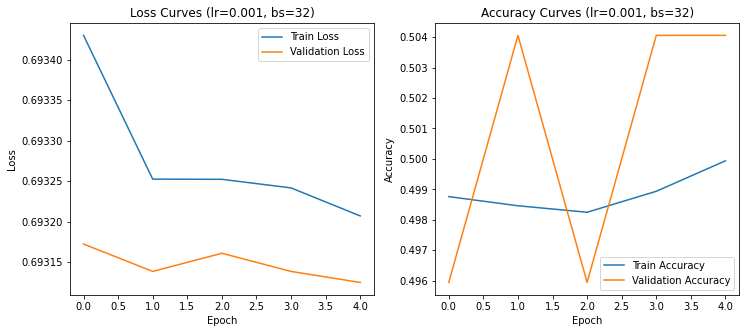


Training with: lr=0.001, hidden_dims=[256, 128, 64], dropout=0.3

Epoch 1/5 -> Train Loss: 0.6876, Train Acc: 0.5446 | Val Loss: 0.6807, Val Acc: 0.5778
Epoch 2/5 -> Train Loss: 0.6782, Train Acc: 0.5863 | Val Loss: 0.6790, Val Acc: 0.5858
Epoch 3/5 -> Train Loss: 0.6733, Train Acc: 0.5824 | Val Loss: 0.6362, Val Acc: 0.6051
Epoch 4/5 -> Train Loss: 0.4526, Train Acc: 0.7885 | Val Loss: 0.3541, Val Acc: 0.8451
Epoch 5/5 -> Train Loss: 0.2983, Train Acc: 0.8795 | Val Loss: 0.3351, Val Acc: 0.8528


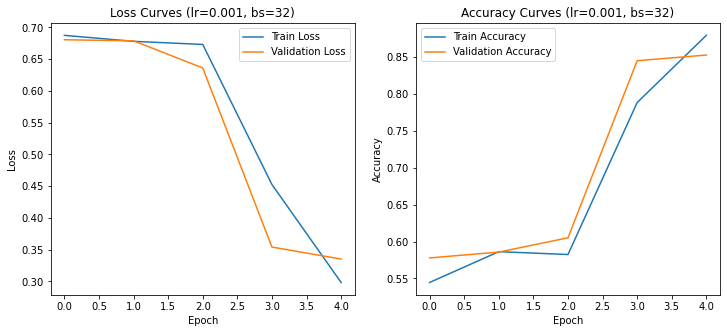


Training with: lr=0.0005, hidden_dims=[128, 64, 32], dropout=0.5

Epoch 1/5 -> Train Loss: 0.6915, Train Acc: 0.5116 | Val Loss: 0.6898, Val Acc: 0.5235
Epoch 2/5 -> Train Loss: 0.6897, Train Acc: 0.5255 | Val Loss: 0.6894, Val Acc: 0.5226
Epoch 3/5 -> Train Loss: 0.5193, Train Acc: 0.7386 | Val Loss: 0.4014, Val Acc: 0.8171
Epoch 4/5 -> Train Loss: 0.3491, Train Acc: 0.8522 | Val Loss: 0.3596, Val Acc: 0.8443
Epoch 5/5 -> Train Loss: 0.2813, Train Acc: 0.8869 | Val Loss: 0.3571, Val Acc: 0.8443


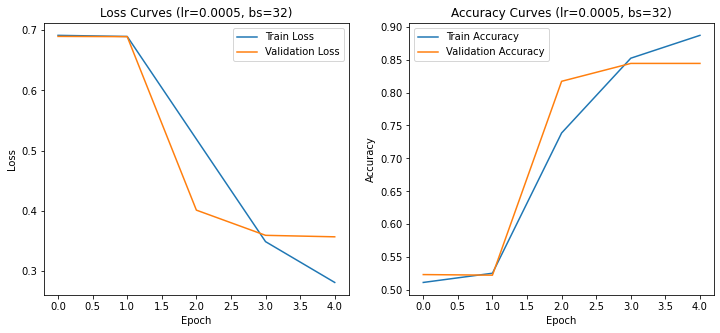


Training with: lr=0.0005, hidden_dims=[128, 64, 32], dropout=0.3

Epoch 1/5 -> Train Loss: 0.6867, Train Acc: 0.5254 | Val Loss: 0.6027, Val Acc: 0.6981
Epoch 2/5 -> Train Loss: 0.4778, Train Acc: 0.7796 | Val Loss: 0.3973, Val Acc: 0.8293
Epoch 3/5 -> Train Loss: 0.3359, Train Acc: 0.8596 | Val Loss: 0.3555, Val Acc: 0.8479
Epoch 4/5 -> Train Loss: 0.2689, Train Acc: 0.8937 | Val Loss: 0.3520, Val Acc: 0.8540
Epoch 5/5 -> Train Loss: 0.2108, Train Acc: 0.9210 | Val Loss: 0.3634, Val Acc: 0.8547


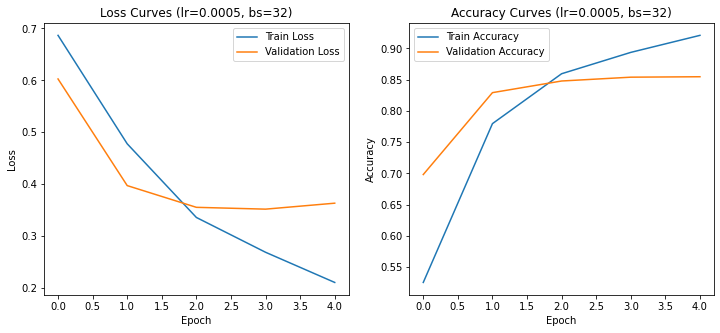


Training with: lr=0.0005, hidden_dims=[256, 128, 64], dropout=0.5

Epoch 1/5 -> Train Loss: 0.6915, Train Acc: 0.5210 | Val Loss: 0.6968, Val Acc: 0.5071
Epoch 2/5 -> Train Loss: 0.6913, Train Acc: 0.5198 | Val Loss: 0.6926, Val Acc: 0.5041
Epoch 3/5 -> Train Loss: 0.6664, Train Acc: 0.5577 | Val Loss: 0.5260, Val Acc: 0.7547
Epoch 4/5 -> Train Loss: 0.4314, Train Acc: 0.8097 | Val Loss: 0.3780, Val Acc: 0.8299
Epoch 5/5 -> Train Loss: 0.3201, Train Acc: 0.8676 | Val Loss: 0.3488, Val Acc: 0.8460


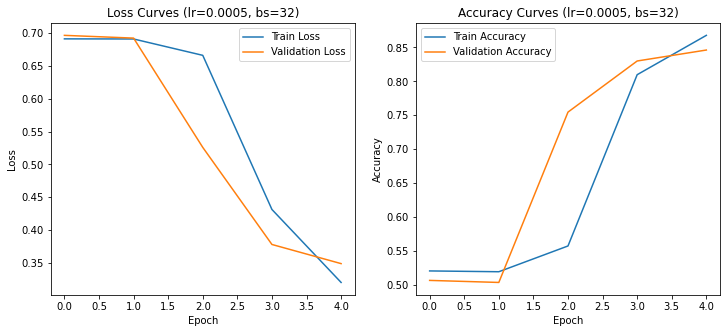


Training with: lr=0.0005, hidden_dims=[256, 128, 64], dropout=0.3

Epoch 1/5 -> Train Loss: 0.6935, Train Acc: 0.4973 | Val Loss: 0.6935, Val Acc: 0.4959
Epoch 2/5 -> Train Loss: 0.6879, Train Acc: 0.5387 | Val Loss: 0.6828, Val Acc: 0.5659
Epoch 3/5 -> Train Loss: 0.6899, Train Acc: 0.5254 | Val Loss: 0.6927, Val Acc: 0.5041
Epoch 4/5 -> Train Loss: 0.6926, Train Acc: 0.5020 | Val Loss: 0.6937, Val Acc: 0.4966
Epoch 5/5 -> Train Loss: 0.6928, Train Acc: 0.5028 | Val Loss: 0.6936, Val Acc: 0.4967


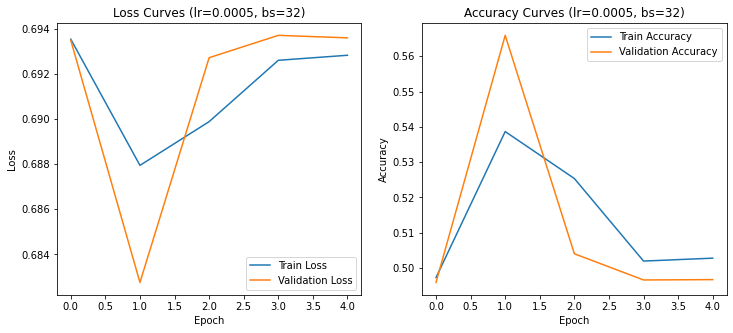

In [34]:
                            # =========================================== # 
                            #    Hyperparameter Tuning (Grid Search)      #
                            # =========================================== #
            

for lr in learning_rates:
        for hidden_dims in hidden_dims_options:
            for dropout in dropout_rates:
                print("\n" + "="*63)
                print(f"Training with: lr={lr}, hidden_dims={hidden_dims}, dropout={dropout}")
                print("="*63 + "\n")
                
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                
                model = LSTM_Sentiment_Model(vocab_size, embedding_dim, hidden_dims, output_size, dropout).to(device)
                
                criterion = nn.BCEWithLogitsLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)
                
                train_losses, train_accuracies, val_losses, val_accuracies = train_LSTM(
                    model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
                
                #Saves the best config
                if val_accuracies[-1] > best_val_acc:
                    best_val_acc = val_accuracies[-1]
                    best_config = {
                        "lr": lr,
                        "batch_size": batch_size,
                        "hidden_dims": hidden_dims,
                        "dropout": dropout,
                        "num_epochs": num_epochs
                    }
                    best_metrics = {
                        "train_losses": train_losses,
                        "train_accuracies": train_accuracies,
                        "val_losses": val_losses,
                        "val_accuracies": val_accuracies
                    }
                    best_model_state = model.state_dict()
                
                #Plots the loss and accuracy curves
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_losses, label='Train Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.title(f"Loss Curves (lr={lr}, bs={batch_size})")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.legend()
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracies, label='Train Accuracy')
                plt.plot(val_accuracies, label='Validation Accuracy')
                plt.title(f"Accuracy Curves (lr={lr}, bs={batch_size})")
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                plt.legend()
                plt.show()            

## `Summary:`


Best Hyperparameter Configuration based on Validation Accuracy:
{'lr': 0.0005, 'batch_size': 32, 'hidden_dims': [128, 64, 32], 'dropout': 0.3, 'num_epochs': 5}
Best Validation Accuracy: 0.8547


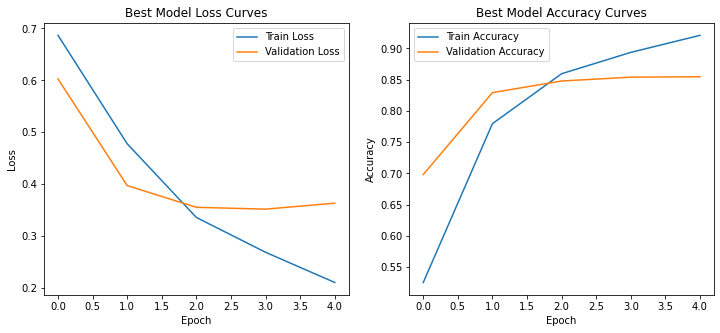

In [35]:
print("\nBest Hyperparameter Configuration based on Validation Accuracy:")
print(best_config)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_metrics["train_losses"], label='Train Loss')
plt.plot(best_metrics["val_losses"], label='Validation Loss')
plt.title("Best Model Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_metrics["train_accuracies"], label='Train Accuracy')
plt.plot(best_metrics["val_accuracies"], label='Validation Accuracy')
plt.title("Best Model Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

3. Evaluation and analysis


Final Test Loss: 0.3668, Final Test Accuracy: 0.8513

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8551    0.8457    0.8504      4991
         1.0     0.8476    0.8569    0.8522      4997

    accuracy                         0.8513      9988
   macro avg     0.8514    0.8513    0.8513      9988
weighted avg     0.8514    0.8513    0.8513      9988



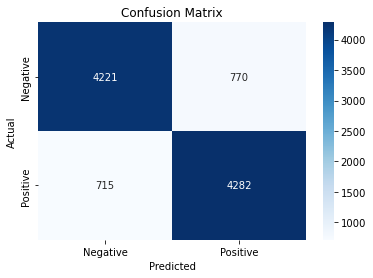

In [36]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False)

#Load the best model
best_model_instance = LSTM_Sentiment_Model(vocab_size, embedding_dim, best_config["hidden_dims"], output_size, best_config["dropout"]).to(device)
best_model_instance.load_state_dict(best_model_state)
best_model_instance.eval()

all_preds = []
all_labels = []
running_test_loss = 0.0

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = best_model_instance(sequences)
        loss = criterion(outputs.view(-1), labels.view(-1))
        running_test_loss += loss.item() * sequences.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

final_test_loss = running_test_loss / len(test_dataset)
final_test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nFinal Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

4. Save the weights of the trained neural network

In [37]:
torch.save(best_model_state, 'base_LSTM.pth')
print("Best model weights saved to 'base_LSTM.pth'")

Best model weights saved to 'base_LSTM.pth'


## Step 3: Improved LSTM Model

1. Improve your baseline LSTM model

In [38]:
from torchtext.vocab import GloVe

pretrained_dim = 100
glove = GloVe(name='6B', dim=pretrained_dim)
vocab_size = len(vocab)
pretrained_embedding_matrix = torch.zeros(vocab_size, pretrained_dim)
stoi = vocab.get_stoi()  
for word, idx in stoi.items():
    if word in glove.stoi:
        pretrained_embedding_matrix[idx] = glove.vectors[glove.stoi[word]]
    else:
        #If not in Glove, init randomly 
        pretrained_embedding_matrix[idx] = torch.randn(pretrained_dim)

In [39]:
                                        # ---------------------- #
                                        #     Improved Model     #
                                        # ---------------------- #
            
class Improved_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dims, output_size, dropout, 
                 pretrained_embeddings=None, bidirectional=True):
        super(Improved_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
        
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)
        
        self.lstm_layers = nn.ModuleList()
        input_dim = embedding_dim
        for i, hidden_dim in enumerate(hidden_dims):
            self.lstm_layers.append(nn.LSTM(
                input_dim, 
                hidden_dim, 
                num_layers=1,      
                batch_first=True, 
                bidirectional=bidirectional
            ))
            input_dim = hidden_dim * (2 if bidirectional else 1)
        
        lstm_output_dim = input_dim
        #Inits the attention layer
        self.attention_layer = nn.Linear(lstm_output_dim, 1)
        self.fc = nn.Linear(lstm_output_dim, output_size)
        
    def attention_net(self, lstm_output):
        attn_weights = torch.tanh(self.attention_layer(lstm_output))
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(lstm_output * attn_weights, dim=1)
        return context, attn_weights

    def forward(self, x):
        embedded = self.embedding(x)
        output = embedded
        for lstm in self.lstm_layers:
            output, _ = lstm(output)
            output = self.dropout(output)
        context, attn_weights = self.attention_net(output)
        output = self.fc(context)
        return output


2. Create a new class for your improved model

In [40]:
    
    
                                    # ----------------------------- #
                                    # Model Parameters and Summary  #
                                    # ----------------------------- #  

#Using dummy input to show summary of model                
dummy_input = torch.randint(0, 10000, (32, 100))
model = Improved_LSTM(10000, 128, [128, 64, 32], 1, 0.5)
summary(model, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
Improved_LSTM                            [32, 1]                   --
├─Embedding: 1-1                         [32, 100, 128]            1,280,000
├─ModuleList: 1-6                        --                        (recursive)
│    └─LSTM: 2-1                         [32, 100, 256]            264,192
├─Dropout: 1-3                           [32, 100, 256]            --
├─ModuleList: 1-6                        --                        (recursive)
│    └─LSTM: 2-2                         [32, 100, 128]            164,864
├─Dropout: 1-5                           [32, 100, 128]            --
├─ModuleList: 1-6                        --                        (recursive)
│    └─LSTM: 2-3                         [32, 100, 64]             41,472
├─Dropout: 1-7                           [32, 100, 64]             --
├─Linear: 1-8                            [32, 100, 1]              65
├─Linear: 1-9                        

In [41]:
                                            # --------- #
                                            #   Setup   #
                                            # --------- #

learning_rates = [0.00015, 0.0002]
batch_sizes = 32
num_epochs = 5
hidden_dims_ = [[128, 64, 32], [192, 128, 64]]
dropouts = [0.5, 0.7]

best_val_acc_improved = 0.0
best_improved_config = None
best_improved_metrics = None
best_improved_model_state = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

3. Follow the same training and evaluation procedures


Improved Model Training: lr=0.00015, hidden_dims=[128, 64, 32], dropout=0.5

Epoch 1/5 -> Train Loss: 0.4704, Train Acc: 0.7710 | Val Loss: 0.3996, Val Acc: 0.8189
Epoch 2/5 -> Train Loss: 0.3486, Train Acc: 0.8480 | Val Loss: 0.3757, Val Acc: 0.8424
Epoch 3/5 -> Train Loss: 0.3012, Train Acc: 0.8743 | Val Loss: 0.3317, Val Acc: 0.8601
Epoch 4/5 -> Train Loss: 0.2692, Train Acc: 0.8894 | Val Loss: 0.3138, Val Acc: 0.8652
Epoch 5/5 -> Train Loss: 0.2412, Train Acc: 0.9035 | Val Loss: 0.3147, Val Acc: 0.8673


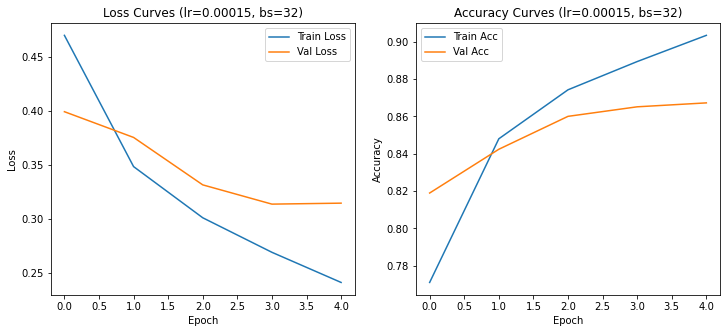


Improved Model Training: lr=0.00015, hidden_dims=[128, 64, 32], dropout=0.7

Epoch 1/5 -> Train Loss: 0.4902, Train Acc: 0.7576 | Val Loss: 0.4094, Val Acc: 0.8170
Epoch 2/5 -> Train Loss: 0.3598, Train Acc: 0.8435 | Val Loss: 0.3426, Val Acc: 0.8504
Epoch 3/5 -> Train Loss: 0.3090, Train Acc: 0.8703 | Val Loss: 0.3302, Val Acc: 0.8617
Epoch 4/5 -> Train Loss: 0.2744, Train Acc: 0.8885 | Val Loss: 0.3244, Val Acc: 0.8656
Epoch 5/5 -> Train Loss: 0.2468, Train Acc: 0.9016 | Val Loss: 0.3340, Val Acc: 0.8676


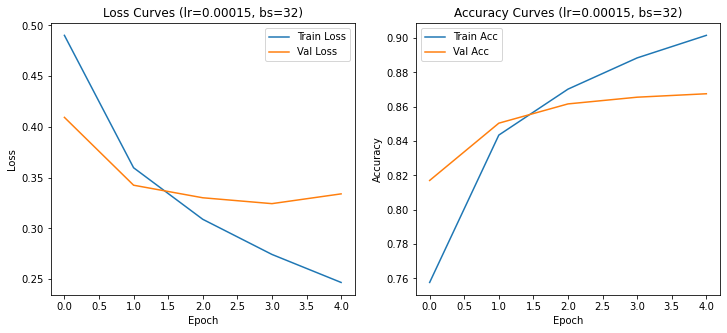


Improved Model Training: lr=0.00015, hidden_dims=[192, 128, 64], dropout=0.5

Epoch 1/5 -> Train Loss: 0.4596, Train Acc: 0.7772 | Val Loss: 0.3745, Val Acc: 0.8320
Epoch 2/5 -> Train Loss: 0.3402, Train Acc: 0.8517 | Val Loss: 0.3272, Val Acc: 0.8548
Epoch 3/5 -> Train Loss: 0.2935, Train Acc: 0.8764 | Val Loss: 0.3135, Val Acc: 0.8618
Epoch 4/5 -> Train Loss: 0.2627, Train Acc: 0.8923 | Val Loss: 0.3156, Val Acc: 0.8664
Epoch 5/5 -> Train Loss: 0.2355, Train Acc: 0.9057 | Val Loss: 0.3113, Val Acc: 0.8678


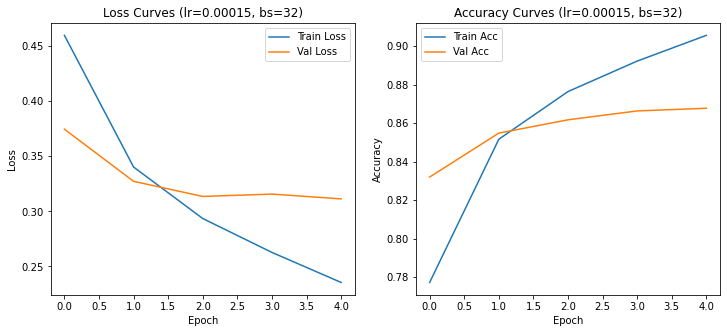


Improved Model Training: lr=0.00015, hidden_dims=[192, 128, 64], dropout=0.7

Epoch 1/5 -> Train Loss: 0.4658, Train Acc: 0.7732 | Val Loss: 0.4185, Val Acc: 0.8110
Epoch 2/5 -> Train Loss: 0.3419, Train Acc: 0.8527 | Val Loss: 0.3812, Val Acc: 0.8345
Epoch 3/5 -> Train Loss: 0.2947, Train Acc: 0.8772 | Val Loss: 0.3233, Val Acc: 0.8617
Epoch 4/5 -> Train Loss: 0.2637, Train Acc: 0.8926 | Val Loss: 0.3148, Val Acc: 0.8644
Epoch 5/5 -> Train Loss: 0.2380, Train Acc: 0.9047 | Val Loss: 0.3259, Val Acc: 0.8658


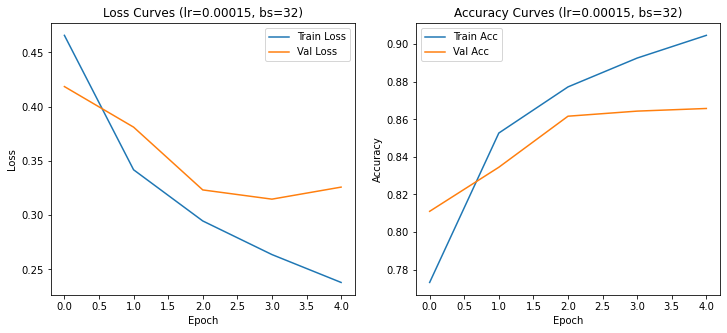


Improved Model Training: lr=0.0002, hidden_dims=[128, 64, 32], dropout=0.5

Epoch 1/5 -> Train Loss: 0.4577, Train Acc: 0.7787 | Val Loss: 0.3639, Val Acc: 0.8391
Epoch 2/5 -> Train Loss: 0.3272, Train Acc: 0.8602 | Val Loss: 0.3265, Val Acc: 0.8603
Epoch 3/5 -> Train Loss: 0.2799, Train Acc: 0.8850 | Val Loss: 0.3387, Val Acc: 0.8501
Epoch 4/5 -> Train Loss: 0.2459, Train Acc: 0.9027 | Val Loss: 0.3202, Val Acc: 0.8650
Epoch 5/5 -> Train Loss: 0.2154, Train Acc: 0.9163 | Val Loss: 0.3263, Val Acc: 0.8678


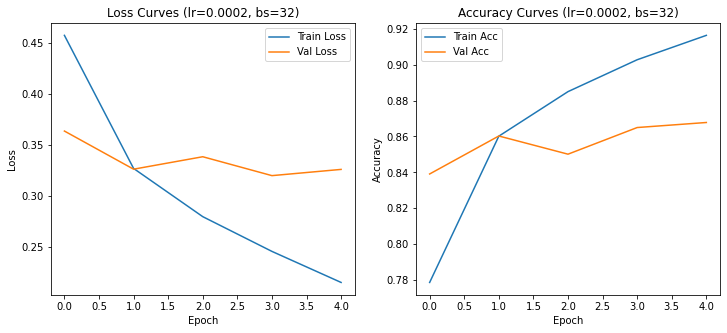


Improved Model Training: lr=0.0002, hidden_dims=[128, 64, 32], dropout=0.7

Epoch 1/5 -> Train Loss: 0.4713, Train Acc: 0.7693 | Val Loss: 0.3895, Val Acc: 0.8309
Epoch 2/5 -> Train Loss: 0.3386, Train Acc: 0.8551 | Val Loss: 0.3398, Val Acc: 0.8592
Epoch 3/5 -> Train Loss: 0.2871, Train Acc: 0.8808 | Val Loss: 0.3306, Val Acc: 0.8620
Epoch 4/5 -> Train Loss: 0.2510, Train Acc: 0.8993 | Val Loss: 0.3325, Val Acc: 0.8702
Epoch 5/5 -> Train Loss: 0.2184, Train Acc: 0.9146 | Val Loss: 0.3522, Val Acc: 0.8679


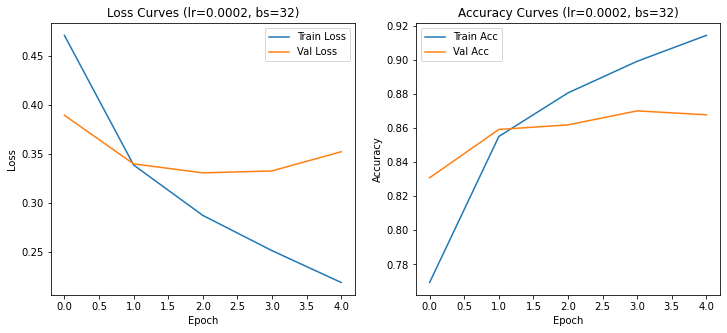


Improved Model Training: lr=0.0002, hidden_dims=[192, 128, 64], dropout=0.5

Epoch 1/5 -> Train Loss: 0.4449, Train Acc: 0.7867 | Val Loss: 0.3552, Val Acc: 0.8424
Epoch 2/5 -> Train Loss: 0.3204, Train Acc: 0.8638 | Val Loss: 0.3265, Val Acc: 0.8593
Epoch 3/5 -> Train Loss: 0.2738, Train Acc: 0.8874 | Val Loss: 0.3099, Val Acc: 0.8642
Epoch 4/5 -> Train Loss: 0.2381, Train Acc: 0.9051 | Val Loss: 0.3089, Val Acc: 0.8692
Epoch 5/5 -> Train Loss: 0.2072, Train Acc: 0.9195 | Val Loss: 0.3194, Val Acc: 0.8685


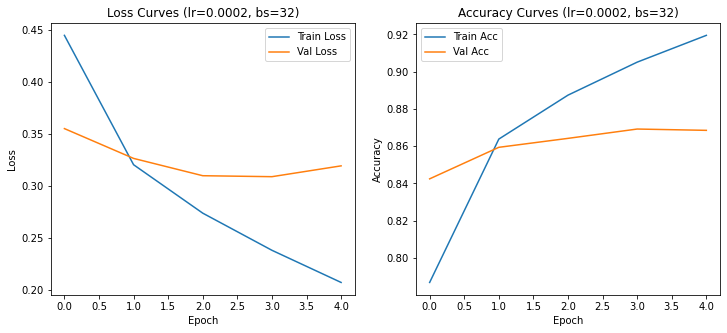


Improved Model Training: lr=0.0002, hidden_dims=[192, 128, 64], dropout=0.7

Epoch 1/5 -> Train Loss: 0.4487, Train Acc: 0.7833 | Val Loss: 0.3755, Val Acc: 0.8306
Epoch 2/5 -> Train Loss: 0.3252, Train Acc: 0.8609 | Val Loss: 0.3247, Val Acc: 0.8598
Epoch 3/5 -> Train Loss: 0.2781, Train Acc: 0.8859 | Val Loss: 0.3182, Val Acc: 0.8655
Epoch 4/5 -> Train Loss: 0.2433, Train Acc: 0.9033 | Val Loss: 0.3025, Val Acc: 0.8692
Epoch 5/5 -> Train Loss: 0.2111, Train Acc: 0.9177 | Val Loss: 0.3293, Val Acc: 0.8696


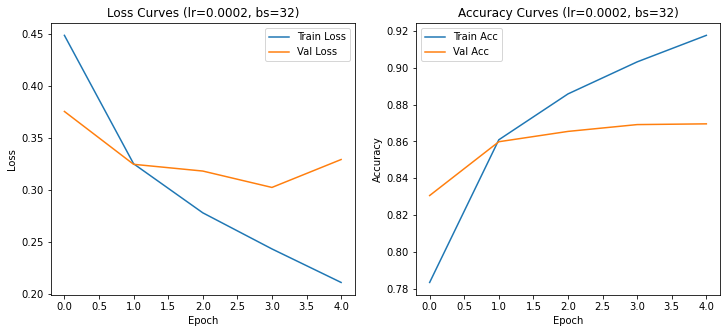

In [42]:
                            # =========================================== # 
                            #    Hyperparameter Tuning (Grid Search)      #
                            # =========================================== #
            
            
for lr in learning_rates:
        for hidden_dims in hidden_dims_:
            for dropout in dropouts:
                
                print("\n" + "="*75)
                print(f"Improved Model Training: lr={lr}, hidden_dims={hidden_dims}, dropout={dropout}")
                print("="*75 + "\n")
                
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                
                model = Improved_LSTM(vocab_size, pretrained_dim, hidden_dims, 1, dropout, 
                                               pretrained_embeddings=pretrained_embedding_matrix, 
                                               bidirectional=True).to(device)
                
                criterion = nn.BCEWithLogitsLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)
                
                train_losses, train_accuracies, val_losses, val_accuracies = train_LSTM(
                    model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
                
                if val_accuracies[-1] > best_val_acc_improved:
                    best_val_acc_improved = val_accuracies[-1]
                    best_improved_config = {
                        "lr": lr,
                        "batch_size": batch_size,
                        "hidden_dims": hidden_dims,
                        "dropout": dropout,
                        "num_epochs": num_epochs
                    }
                    best_improved_metrics = {
                        "train_losses": train_losses,
                        "train_accuracies": train_accuracies,
                        "val_losses": val_losses,
                        "val_accuracies": val_accuracies
                    }
                    best_improved_model_state = model.state_dict()
                
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_losses, label='Train Loss')
                plt.plot(val_losses, label='Val Loss')
                plt.title(f"Loss Curves (lr={lr}, bs={batch_size})")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.legend()
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracies, label='Train Acc')
                plt.plot(val_accuracies, label='Val Acc')
                plt.title(f"Accuracy Curves (lr={lr}, bs={batch_size})")
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                plt.legend()
                plt.show()

## `Summary:`


Best Improved Model Configuration based on Validation Accuracy:
{'lr': 0.0002, 'batch_size': 32, 'hidden_dims': [192, 128, 64], 'dropout': 0.7, 'num_epochs': 5}
Best Validation Accuracy (Improved): 0.8696


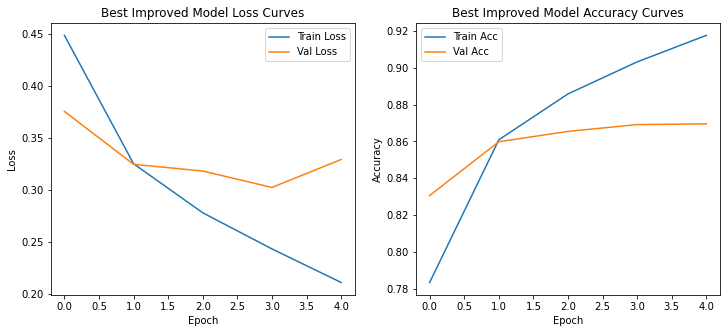

In [43]:
print("\nBest Improved Model Configuration based on Validation Accuracy:")
print(best_improved_config)
print(f"Best Validation Accuracy (Improved): {best_val_acc_improved:.4f}")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_improved_metrics["train_losses"], label='Train Loss')
plt.plot(best_improved_metrics["val_losses"], label='Val Loss')
plt.title("Best Improved Model Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_improved_metrics["train_accuracies"], label='Train Acc')
plt.plot(best_improved_metrics["val_accuracies"], label='Val Acc')
plt.title("Best Improved Model Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs.view(-1), labels.view(-1))
            running_loss += loss.item() * sequences.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (preds.view(-1) == labels.view(-1)).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc, all_preds, all_labels


[Improved Model] Test Loss: 0.3265, Test Accuracy: 0.8764

[Improved Model] Classification Report:
              precision    recall  f1-score   support

         0.0     0.8850    0.8650    0.8749      4991
         1.0     0.8681    0.8877    0.8778      4997

    accuracy                         0.8764      9988
   macro avg     0.8765    0.8763    0.8763      9988
weighted avg     0.8765    0.8764    0.8763      9988



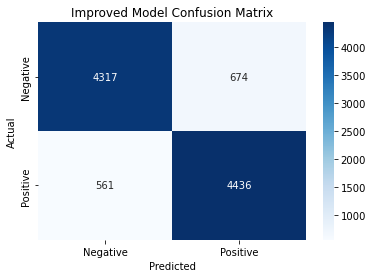

In [46]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

best_improved_model = Improved_LSTM(vocab_size, pretrained_dim, 
                                             best_improved_config["hidden_dims"], 1, 
                                             best_improved_config["dropout"],
                                             pretrained_embeddings=pretrained_embedding_matrix, 
                                             bidirectional=True).to(device)
best_improved_model.load_state_dict(best_improved_model_state)

criterion = nn.BCEWithLogitsLoss()

improved_test_loss, improved_test_acc, improved_preds, improved_labels = evaluate_model(
    best_improved_model, test_loader, criterion, device)

print(f"\n[Improved Model] Test Loss: {improved_test_loss:.4f}, Test Accuracy: {improved_test_acc:.4f}")
print("\n[Improved Model] Classification Report:")
print(classification_report(improved_labels, improved_preds, digits=4))

cm_improved = confusion_matrix(improved_labels, improved_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Improved Model Confusion Matrix')
plt.show()

4. Directly compare the performance of your improved model to the baseline model

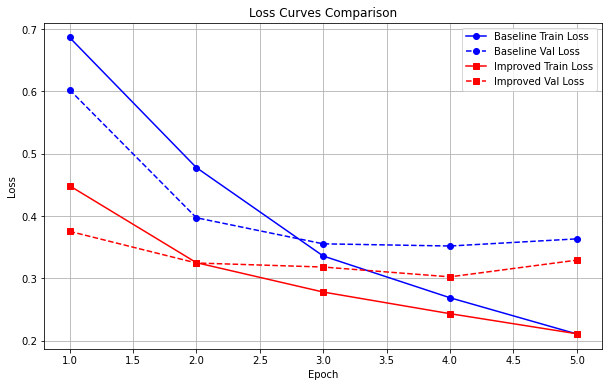

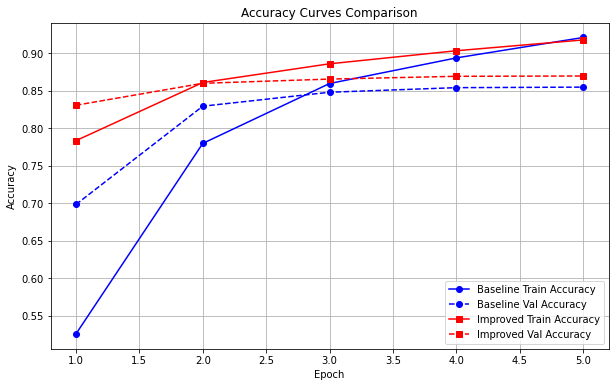

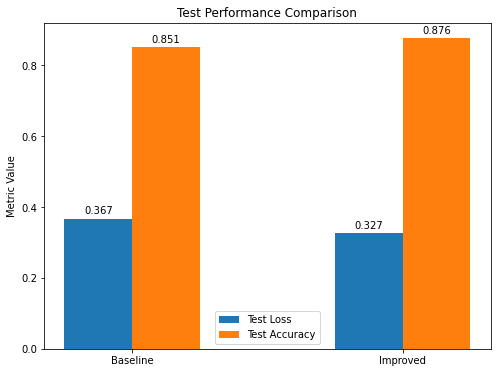

In [63]:
epochs = range(1, len(best_metrics["train_losses"]) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, best_metrics["train_losses"], label="Baseline Train Loss", marker='o', linestyle='-',color="blue")
plt.plot(epochs, best_metrics["val_losses"], label="Baseline Val Loss", marker='o', linestyle='--',color="blue")
plt.plot(epochs, best_improved_metrics["train_losses"], label="Improved Train Loss", marker='s', linestyle='-',color="red")
plt.plot(epochs, best_improved_metrics["val_losses"], label="Improved Val Loss", marker='s', linestyle='--',color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(epochs, best_metrics["train_accuracies"], label="Baseline Train Accuracy", marker='o', linestyle='-',color="blue")
plt.plot(epochs, best_metrics["val_accuracies"], label="Baseline Val Accuracy", marker='o', linestyle='--',color="blue")
plt.plot(epochs, best_improved_metrics["train_accuracies"], label="Improved Train Accuracy", marker='s', linestyle='-',color="red")
plt.plot(epochs, best_improved_metrics["val_accuracies"], label="Improved Val Accuracy", marker='s', linestyle='--',color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()


# Create a grouped bar chart comparing test loss and test accuracy for both models.
models = ["Baseline", "Improved"]
# For baseline model, using final_test_loss and final_text_acc (adjust key if necessary)
test_losses = [final_test_loss, improved_test_loss]
test_accuracies = [final_test_acc, improved_test_acc]  # Use final_test_acc if that's the correct variable

x = np.arange(len(models))  # positions for the groups
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(8,6))
bars_loss = ax.bar(x - width/2, test_losses, width, label='Test Loss')
bars_acc = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel("Metric Value")
ax.set_title("Test Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(bars, fmt="%.3f"):
    """Attach a text label above each bar displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(fmt % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset in points
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars_loss, fmt="%.3f")
autolabel(bars_acc, fmt="%.3f")

plt.show()


Both the training and validation loss/accuracy curves of the two models both clearly indicate the impact of the improvements. The baseline model's curves both show a slight higher variance between training and validation accuracy, which tells us there is some overfitting. Furthermore, its loss curve has a slower rate of convergence, indicating that the model was inefficient in learning useful representations. On the other hand, the improved model indicates a more stable and consistent convergence, with a closely closed gap in training and validation performance across. This tells us that the introduction of GloVe embeddings, bidirectional LSTMs, and the attention mechanism significantly improved the ability of the model to generalize from unseen data. 

This is complemented by the improved test accuracy and lower test loss of the improved model. The increase in accuracy from 85.13% to 87.64% and reduction in test loss from 0.3668 to 0.3265 indicate a better understanding of sentiment signals in the dataset. The attention component likely helped the model pay more attention to the most effective words in reviews, while the bidirectional LSTMs were capable of better capturing contextual relationships. The lower loss curve of the more accurate model also reflects more stable training, thus a safer choice for real-world sentiment analysis applications.

5. Save the weights of the trained neural network

In [47]:
torch.save(best_improved_model_state, 'improved_LSTM.pth')
print("\nBest improved model weights saved to 'improved_LSTM.pth'")


Best improved model weights saved to 'improved_LSTM.pth'


## Step 4: Discussion

1. Briefly describe the dataset and its key characteristics

I used the Amazon Reviews Polity dataset, characterized by: 

- **Content:** Each data point has a title, text of review, and sentiment class. Balance: The data was balanced 50% negative vs. 50% positive reviews.
- **Size:** I had utilized 100,000 data points, having left out a couple of missing cases.
- **Review Length:** On an average, each review contains some 74 words (or 406 characters), though there's quite some difference.
- **Preprocessing:** Tasks included removal of reviews written in non-English languages(spanish here), text cleaning (lowercasing, special characters removal, and stopwords removal), and tokenization to handle a huge vocabulary.

2. Describe both your baseline and improved LSTM architectures in detail

- **Baseline LSTM Model:**
    -  Embedding Layer: Embeds every word index into a 128-dimensional vector.
    -  Stacked LSTM Layers: Three layers with hidden dimensions [128, 64, 32]. A dropout layer follows each layer to avoid overfitting.  -
    -  Output Layer: The output at the final time step passed through a fully connected network, with an intermediate ReLU activation, to produce a single logit for binary sentiment classification.<br><br>


- **Improved LSTM Model:**
    - Embedding Layer: Uses pre-trained GloVe embeddings (100-dimensional) that have more semantic information.
    - Bidirectional LSTMs: Stacked bidirectional LSTM layers allow the model to capture context from both directions of the sequence.
    - Attention Mechanism: An attention layer computes weights over the LSTM outputs, highlighting important parts of the review before aggregating them into a context vector.
    - Final Classification: The context vector is passed through a fully connected layer to generate the final sentiment prediction.

3. Discuss the results, comparing the performance of the baseline and improved models

- **Baseline Model:**
I used a simple architecture consisting of a 128-dimensional embedding layer, then three LSTM layers with hidden sizes: 128, 64, 32 interleaved with dropout (best was 0.3). Training loss for the model declined smoothly over five epochs, yet the validation loss hit its plateau point sooner, which implies challenge in grasping finer sentiment clues—see test accuracy at ~85.13% and loss of ~0.3668.

- **Improved Model:**
I added improvements to the baseline by:

    - Utilizing Pre-trained GloVe Embeddings: (100-dimensional) for richer semantic representations.
    - Substituting with Bidirectional LSTMs: to receive context from both sides.
    - Implementing an Attention Mechanism: to focus on sentiment-critical sections of the review.
      
With the best setup (lr=0.0002, hidden dimensions [192, 128, 64], dropout=0.7), the improved model converged more uniformly and achieved a test accuracy of ~87.64% and a loss of ~0.3265.

**Attribution of Improvements:**
The performance gains are achieved through starting with semantically rich GloVe embeddings, increased context modeling using bidirectional LSTMs, and strategic feature extraction from the attention layer, all resulting in improved generalization and stability.

4. Discuss the strengths and limitations of using recurrent neural models for sentiment analysis

**Strengths:**

- Sequential Processing: LSTMs are inherently suited to process sequences, capturing temporal dependencies critical to sentiment comprehension.
- Long-term Dependencies: Gating mechanisms enable them to maintain context over longer sequences, beneficial in sentiment analysis.
- Enhancements: Bidirectionality and attention can be incorporated to further enhance performance by increasing context capture and emphasizing relevant information.

**Limitations:**
- Processing Very Long Sequences: Despite their design, LSTMs can still lose prominent information if sequences are too truncated.
- Computational Expense: LSTMs, especially if bidirectional or stacked, are more computationally expensive than other lighter models like logistic regression.
- Sensitivity to Hyperparameters: The performance of LSTMs is highly sensitive to meticulous tuning of hyperparameters such as learning rate, dropout, and hidden layer sizes.
- Interpretability: Although attention mechanisms provide some interpretability, LSTMs are "black boxes" compared to more interpretable models.

5. References. Include details on all the resources used to complete this part.

- **Amazon Reviews Dataset**  
  The Amazon reviews dataset consists of reviews from Amazon spanning 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. For more details, see: McAuley, J. & Leskovec, J. (2013). *Hidden factors and hidden topics: Understanding rating dimensions with review text*. In Proceedings of RecSys 2013.

- **GloVe Embeddings**  
  Pennington, J., Socher, R., & Manning, C. D. (2014). *GloVe: Global Vectors for Word Representation*. In EMNLP.

- **Long Short-Term Memory (LSTM)**  
  Hochreiter, S. & Schmidhuber, J. *Long Short-Term Memory*. Neural Computation, 9(8), 1735–1780.

- **Attention Mechanism**  
  Bahdanau, D., Cho, K., & Bengio, Y. (2014). *Neural Machine Translation by Jointly Learning to Align and Translate*. In ICLR.